## Implementation of 'Deep neural networks for accurate predictions of Crystal Stability [1]"

This Notebook implements a deep neural network (6 - 24 -1) for prediction formation energy for unmixed garnets. A dataset containing 700 data samples of different garnets structures ($C_3A_2D_3O_{12}$) with thier formation energies ($E_f$) were used in this implementation. For training and testing purposes the dataset was divided in to 70%, 10%, 20% for training, validation and testing respectively. The code used to implement this Artificial Neural Network is demonstrated below with plots showing the training, testing losses and the final result. 



In [ ]:
import json
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from pymatgen.core.periodic_table import get_el_sp
from pymatgen.core import Composition
from monty.serialization import loadfn
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [ ]:
class NeuralNet(tf.keras.Model):

    """  This class creates a neural network layer taking in the number of layer ana
    number of units arguments """

    def __init__(self, nnShape):
        super(NeuralNet, self).__init__()
        
        self.nnShape = nnShape
        
        self.collectionLayer = []
        
        self.layer1 = tf.keras.layers.Dense(self.nnShape[0], activation= 'relu')
        
        for i in self.nnShape[1:-1]:
            self.collectionLayer.append(tf.keras.layers.Dense(i, activation='relu'))
        
#         self.layer1 =  tf.keras.layers.Dense(128, activation = 'relu')
#         self.layer2 = tf.keras.layers.Dense(64, activation = 'relu')
#         self.layer3 =  tf.keras.layers.Dense(32, activation = 'relu')
     
        self.layerlast = tf.keras.layers.Dense(self.nnShape[-1])



    def call(self, inputs):
        
#         x = self.collectionLayer[0](inputs)
        
#         self.collectionLayer.pop(0)

#         for lyr in self.collectionLayer:
#             x = lyr(x)

        x = self.layer1(inputs)
        
        for lyr in self.collectionLayer:
            
            x = lyr(x)
                                
        y = self.layerlast(x)

        return y
    
    def summary(self):
        
        inputs = tf.keras.Input(shape=(6,), batch_size=5) 
        
        model = tf.keras.Model(inputs = inputs, outputs = self.call(inputs))
        
        return model.summary()




In [ ]:
nnShape = [256, 128,64,32,1]
mymodel = NeuralNet(nnShape= nnShape)
mymodel.compile(loss = "mse",
          metrics   = "mae",
          optimizer = tf.keras.optimizers.Adam(lr=0.01))

print(mymodel.summary())

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(5, 6)]                  0         
_________________________________________________________________
dense_235 (Dense)            (5, 256)                  1792      
_________________________________________________________________
dense_236 (Dense)            (5, 128)                  32896     
_________________________________________________________________
dense_237 (Dense)            (5, 64)                   8256      
_________________________________________________________________
dense_238 (Dense)            (5, 32)                   2080      
_________________________________________________________________
dense_239 (Dense)            (5, 1)                    33        
Total params: 45,057
Trainable params: 45,057
Non-trainable params: 0
_________________________________________________

In [ ]:
def dataGenerator():
    
    df = pd.read_csv('./data/garnet/newData/garnet.csv')

    print(df.columns.values)

    outputData = df['FormEnergyPerAtom'].to_numpy()
#     outputData=  outputData.reshape((outputData.shape[0], 1))

    C_ionicRd = df['C-IonicRadius'].to_numpy()
    C_ionicRd = C_ionicRd.reshape((C_ionicRd.shape[0], 1))

    C_pauling = df['C-ElectroNegativity'].to_numpy()
    C_pauling = C_pauling.reshape((C_pauling.shape[0], 1))

    A_ionicRd = df['A-IonicRadius'].to_numpy()
    A_ionicRd = A_ionicRd.reshape((A_ionicRd.shape[0], 1))

    A_pauling = df['A-ElectroNegativity'].to_numpy()
    A_pauling = A_pauling.reshape((A_pauling.shape[0], 1))

    D_ionicRd = df['D-IonicRadius'].to_numpy()
    D_ionicRd = D_ionicRd.reshape((D_ionicRd.shape[0], 1))

    D_pauling = df['D-ElectroNegativity'].to_numpy()
    D_pauling = D_pauling.reshape((D_pauling.shape[0], 1))

    inputData = np.concatenate([C_ionicRd, C_pauling, A_ionicRd, A_pauling, D_ionicRd, D_pauling], axis=1)
    
    inputData = inputData[0:700,:]
    outputData = outputData[0:700]

    print(inputData.shape, outputData.shape)



    return inputData, outputData


def dataSplitter(inputData, outputData, rand_index):

    nSamples = inputData.shape[0]

    TRAIN = round(0.7*nSamples)
    VAL = round(0.1*nSamples)
    TEST = round(0.2*nSamples)



    # Shuffle the data

    # rand_index = np.random.permutation(635)

    inputData = inputData[rand_index]

    outputData = outputData[rand_index]

    # Split the data for training and testing

    # print(TRAIN+VAL+TEST)

    train_inputData = inputData[0:TRAIN]
    train_outputData = outputData[0:TRAIN]

    val_inputData = inputData[TRAIN:TRAIN+VAL]
    val_outputData = outputData[TRAIN:TRAIN+VAL]

    test_inputData = inputData[TRAIN+VAL:TRAIN+VAL+TEST]
    test_outputData = outputData[TRAIN+VAL:TRAIN+VAL+TEST]

    return train_inputData,train_outputData, val_inputData, val_outputData, test_inputData, test_outputData

In [ ]:
def createModel():

    input = tf.keras.Input(shape=(6,), batch_size=5)

    layer1 = tf.keras.layers.Dense(units=24, activation='relu')(input)
    
#     layer2 = tf.keras.layers.Dense(units=64, activation='relu')(layer1)
    
    
#     layer3 = tf.keras.layers.Dense(units=32, activation='relu')(layer2)

    output = tf.keras.layers.Dense(units=1)(layer1)

    model = tf.keras.Model(inputs=input, outputs=output, name="CrystalDNN")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse',metrics= 'mae')

    return model


In [ ]:
inputData, outputData = dataGenerator()

rand_index = np.random.permutation(inputData.shape[0])

train_inputData,train_outputData, val_inputData, val_outputData, test_inputData, test_outputData = dataSplitter(inputData, outputData,rand_index)
print( train_outputData.shape)


ss = StandardScaler()

ss.fit(train_inputData)

train_inputData_scale = ss.transform(train_inputData)
test_inputData_scale =  ss.transform(test_inputData)
val_inputData_scale =  ss.transform(val_inputData)



# model = createModel()

['c' 'a' 'd' 'C-IonicRadius' 'C-ElectroNegativity' 'A-IonicRadius'
 'A-ElectroNegativity' 'D-IonicRadius' 'D-ElectroNegativity'
 'FormEnergyPerAtom']
(700, 6) (700,)
(490,)


In [ ]:
history = mymodel.fit(x=train_inputData_scale, y=train_outputData,batch_size=5, epochs = 500,
                    validation_data=(val_inputData_scale,val_outputData), validation_batch_size=5)

Epoch 1/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0221 - mae: 0.0846 - val_loss: 0.0050 - val_mae: 0.0560
Epoch 2/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0046 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 3/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0295 - val_loss: 0.0017 - val_mae: 0.0278
Epoch 4/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0337 - val_loss: 0.0018 - val_mae: 0.0287
Epoch 5/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0312 - val_loss: 0.0023 - val_mae: 0.0333
Epoch 6/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0016 - val_mae: 0.0268
Epoch 7/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0018 - val_mae: 0.0284
Epoch 8/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0018 - m

98/98 [==============================] - 0s 2ms/step - loss: 5.2487e-04 - mae: 0.0160 - val_loss: 6.5640e-04 - val_mae: 0.0167
Epoch 62/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0020 - val_mae: 0.0340
Epoch 63/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0328 - val_loss: 0.0019 - val_mae: 0.0340
Epoch 64/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0266 - val_loss: 0.0024 - val_mae: 0.0323
Epoch 65/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0019 - val_mae: 0.0338
Epoch 66/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0282 - val_loss: 0.0015 - val_mae: 0.0255
Epoch 67/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0304 - val_loss: 0.0028 - val_mae: 0.0394
Epoch 68/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0012 

98/98 [==============================] - 0s 2ms/step - loss: 3.6762e-04 - mae: 0.0148 - val_loss: 6.5087e-04 - val_mae: 0.0202
Epoch 121/500
98/98 [==============================] - 0s 2ms/step - loss: 2.8222e-04 - mae: 0.0126 - val_loss: 6.9950e-04 - val_mae: 0.0196
Epoch 122/500
98/98 [==============================] - 0s 2ms/step - loss: 2.8485e-04 - mae: 0.0126 - val_loss: 3.7575e-04 - val_mae: 0.0143
Epoch 123/500
98/98 [==============================] - 0s 2ms/step - loss: 1.9466e-04 - mae: 0.0106 - val_loss: 3.1335e-04 - val_mae: 0.0132
Epoch 124/500
98/98 [==============================] - 0s 2ms/step - loss: 2.8012e-04 - mae: 0.0124 - val_loss: 0.0013 - val_mae: 0.0316
Epoch 125/500
98/98 [==============================] - 0s 2ms/step - loss: 6.0404e-04 - mae: 0.0187 - val_loss: 4.8083e-04 - val_mae: 0.0162
Epoch 126/500
98/98 [==============================] - 0s 2ms/step - loss: 2.4436e-04 - mae: 0.0119 - val_loss: 5.3794e-04 - val_mae: 0.0188
Epoch 127/500
98/98 [==========

98/98 [==============================] - 0s 2ms/step - loss: 3.1151e-04 - mae: 0.0137 - val_loss: 4.8463e-04 - val_mae: 0.0155
Epoch 179/500
98/98 [==============================] - 0s 2ms/step - loss: 1.7682e-04 - mae: 0.0102 - val_loss: 3.9300e-04 - val_mae: 0.0138
Epoch 180/500
98/98 [==============================] - 0s 2ms/step - loss: 2.2699e-04 - mae: 0.0115 - val_loss: 3.7323e-04 - val_mae: 0.0149
Epoch 181/500
98/98 [==============================] - 0s 2ms/step - loss: 2.9708e-04 - mae: 0.0130 - val_loss: 2.7070e-04 - val_mae: 0.0112
Epoch 182/500
98/98 [==============================] - 0s 2ms/step - loss: 2.0413e-04 - mae: 0.0107 - val_loss: 2.9642e-04 - val_mae: 0.0129
Epoch 183/500
98/98 [==============================] - 0s 2ms/step - loss: 2.1957e-04 - mae: 0.0111 - val_loss: 2.1479e-04 - val_mae: 0.0102
Epoch 184/500
98/98 [==============================] - 0s 2ms/step - loss: 1.2044e-04 - mae: 0.0083 - val_loss: 2.2306e-04 - val_mae: 0.0105
Epoch 185/500
98/98 [======

98/98 [==============================] - 0s 2ms/step - loss: 2.3717e-04 - mae: 0.0113 - val_loss: 4.4635e-04 - val_mae: 0.0166
Epoch 237/500
98/98 [==============================] - 0s 2ms/step - loss: 1.4283e-04 - mae: 0.0089 - val_loss: 3.5576e-04 - val_mae: 0.0137
Epoch 238/500
98/98 [==============================] - 0s 2ms/step - loss: 1.8502e-04 - mae: 0.0107 - val_loss: 3.3285e-04 - val_mae: 0.0143
Epoch 239/500
98/98 [==============================] - 0s 2ms/step - loss: 2.6935e-04 - mae: 0.0127 - val_loss: 4.7393e-04 - val_mae: 0.0185
Epoch 240/500
98/98 [==============================] - 0s 2ms/step - loss: 1.7442e-04 - mae: 0.0103 - val_loss: 3.3248e-04 - val_mae: 0.0137
Epoch 241/500
98/98 [==============================] - 0s 2ms/step - loss: 1.5497e-04 - mae: 0.0099 - val_loss: 2.2498e-04 - val_mae: 0.0107
Epoch 242/500
98/98 [==============================] - 0s 2ms/step - loss: 1.7841e-04 - mae: 0.0099 - val_loss: 5.6017e-04 - val_mae: 0.0167
Epoch 243/500
98/98 [======

98/98 [==============================] - 0s 2ms/step - loss: 2.0874e-04 - mae: 0.0108 - val_loss: 3.7526e-04 - val_mae: 0.0149
Epoch 295/500
98/98 [==============================] - 0s 2ms/step - loss: 1.7070e-04 - mae: 0.0102 - val_loss: 5.5425e-04 - val_mae: 0.0209
Epoch 296/500
98/98 [==============================] - 0s 2ms/step - loss: 2.2441e-04 - mae: 0.0117 - val_loss: 3.5692e-04 - val_mae: 0.0142
Epoch 297/500
98/98 [==============================] - 0s 2ms/step - loss: 2.4578e-04 - mae: 0.0123 - val_loss: 9.2536e-04 - val_mae: 0.0247
Epoch 298/500
98/98 [==============================] - 0s 2ms/step - loss: 5.6165e-04 - mae: 0.0184 - val_loss: 3.0507e-04 - val_mae: 0.0130
Epoch 299/500
98/98 [==============================] - 0s 2ms/step - loss: 1.5225e-04 - mae: 0.0091 - val_loss: 2.4439e-04 - val_mae: 0.0122
Epoch 300/500
98/98 [==============================] - 0s 2ms/step - loss: 1.2426e-04 - mae: 0.0084 - val_loss: 3.1463e-04 - val_mae: 0.0125
Epoch 301/500
98/98 [======

98/98 [==============================] - 0s 2ms/step - loss: 1.3141e-04 - mae: 0.0092 - val_loss: 3.0659e-04 - val_mae: 0.0122
Epoch 353/500
98/98 [==============================] - 0s 2ms/step - loss: 1.6372e-04 - mae: 0.0096 - val_loss: 3.3334e-04 - val_mae: 0.0133
Epoch 354/500
98/98 [==============================] - 0s 2ms/step - loss: 1.3189e-04 - mae: 0.0090 - val_loss: 2.4397e-04 - val_mae: 0.0112
Epoch 355/500
98/98 [==============================] - 0s 2ms/step - loss: 1.2147e-04 - mae: 0.0087 - val_loss: 2.7637e-04 - val_mae: 0.0112
Epoch 356/500
98/98 [==============================] - 0s 2ms/step - loss: 1.5204e-04 - mae: 0.0097 - val_loss: 5.0965e-04 - val_mae: 0.0194
Epoch 357/500
98/98 [==============================] - 0s 2ms/step - loss: 1.9053e-04 - mae: 0.0111 - val_loss: 2.3742e-04 - val_mae: 0.0111
Epoch 358/500
98/98 [==============================] - 0s 2ms/step - loss: 1.6698e-04 - mae: 0.0097 - val_loss: 3.3433e-04 - val_mae: 0.0122
Epoch 359/500
98/98 [======

98/98 [==============================] - 0s 2ms/step - loss: 2.0723e-04 - mae: 0.0102 - val_loss: 5.5490e-04 - val_mae: 0.0206
Epoch 411/500
98/98 [==============================] - 0s 2ms/step - loss: 2.4875e-04 - mae: 0.0117 - val_loss: 3.3575e-04 - val_mae: 0.0131
Epoch 412/500
98/98 [==============================] - 0s 2ms/step - loss: 1.5836e-04 - mae: 0.0093 - val_loss: 3.8265e-04 - val_mae: 0.0151
Epoch 413/500
98/98 [==============================] - 0s 2ms/step - loss: 1.2774e-04 - mae: 0.0087 - val_loss: 4.0188e-04 - val_mae: 0.0128
Epoch 414/500
98/98 [==============================] - 0s 2ms/step - loss: 1.0635e-04 - mae: 0.0077 - val_loss: 2.8580e-04 - val_mae: 0.0119
Epoch 415/500
98/98 [==============================] - 0s 2ms/step - loss: 1.1473e-04 - mae: 0.0084 - val_loss: 2.7285e-04 - val_mae: 0.0109
Epoch 416/500
98/98 [==============================] - 0s 2ms/step - loss: 1.4620e-04 - mae: 0.0094 - val_loss: 3.0609e-04 - val_mae: 0.0126
Epoch 417/500
98/98 [======

98/98 [==============================] - 0s 2ms/step - loss: 3.0020e-04 - mae: 0.0138 - val_loss: 5.2144e-04 - val_mae: 0.0194
Epoch 469/500
98/98 [==============================] - 0s 2ms/step - loss: 2.0666e-04 - mae: 0.0111 - val_loss: 3.9875e-04 - val_mae: 0.0154
Epoch 470/500
98/98 [==============================] - 0s 2ms/step - loss: 2.8176e-04 - mae: 0.0132 - val_loss: 2.9464e-04 - val_mae: 0.0111
Epoch 471/500
98/98 [==============================] - 0s 2ms/step - loss: 2.0561e-04 - mae: 0.0109 - val_loss: 3.0967e-04 - val_mae: 0.0120
Epoch 472/500
98/98 [==============================] - 0s 2ms/step - loss: 1.6068e-04 - mae: 0.0097 - val_loss: 2.9783e-04 - val_mae: 0.0117
Epoch 473/500
98/98 [==============================] - 0s 2ms/step - loss: 1.5476e-04 - mae: 0.0093 - val_loss: 2.2906e-04 - val_mae: 0.0106
Epoch 474/500
98/98 [==============================] - 0s 2ms/step - loss: 1.7161e-04 - mae: 0.0099 - val_loss: 3.0976e-04 - val_mae: 0.0128
Epoch 475/500
98/98 [======

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

Text(0, 0.5, 'MAE')

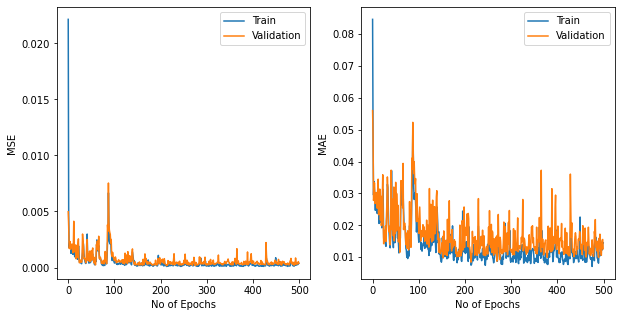

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('MSE')

plt.subplot(122)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('MAE')

In [ ]:
Ef_predicted = mymodel.predict(x= test_inputData_scale)

In [ ]:
# print(Ef_predicted, Ef_predicted.shape)

In [ ]:
np.amax(Ef_predicted)
np.amin(Ef_predicted)

-0.44041413

Text(0, 0.5, '$Ef_{ANN}$ (eV/atom)')

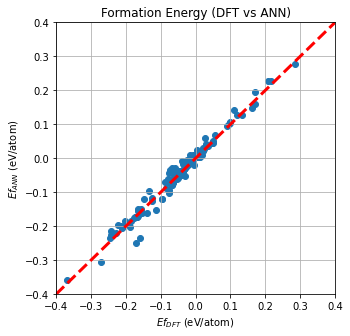

In [ ]:
Ef_actual = test_outputData

# print(Ef_actual-Ef_predicted)

plt.figure(figsize=(5,5))
plt.scatter(Ef_predicted,Ef_actual)

xpoints =  plt.xlim([-0.4,0.4])
ypoints = plt.ylim([-0.4,0.4])

plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=3, scalex=False, scaley=False)

plt.title('Formation Energy (DFT vs ANN)')
plt.grid()
plt.xlabel(r'$Ef_{DFT}$ (eV/atom)')
plt.ylabel(r'$Ef_{ANN}$ (eV/atom)')

## References

[1] Ye, Weike, et al. "Deep neural networks for accurate predictions of crystal stability." Nature communications 9.1 (2018): 1-6.